### Setup

#### Automatic reloading and inline plotting

In [84]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Import fastai libraries

In [105]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import numpy as np
from sklearn import metrics

#### Setup global variables

In [86]:
PATH = "../data/dogbreed"

#### Check GPU are working

In [87]:
torch.cuda.is_available()

True

### Data Inspection

#### Read the given csv

In [88]:
df = pd.read_csv(f'{PATH}/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [89]:
df_by_breed = df.pivot_table(aggfunc=len, index="breed")
df_by_breed.sort_values(by="id", ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


#### Read one training image

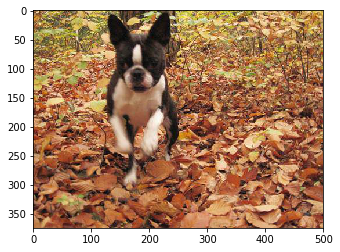

In [90]:
train_file_names = os.listdir(f'{PATH}/train/')
train_img = plt.imread(f'{PATH}/train/{train_file_names[0]}')
plt.imshow(train_img)

In [91]:
train_img.shape

(375, 500, 3)

In [92]:
filename_shape_map = {file_name: PIL.Image.open(f'{PATH}/train/{file_name}').size for file_name in train_file_names}

In [93]:
row_size, col_size = zip(*filename_shape_map.values())

(array([3798., 6259.,  108.,   18.,   11.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

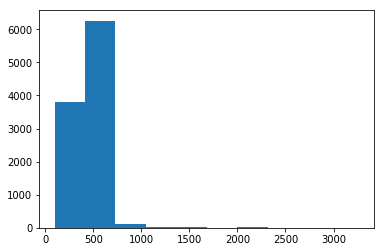

In [94]:
plt.hist(row_size)

(array([3595., 6395.,  150.,   28.,   18.,   20.,   10.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

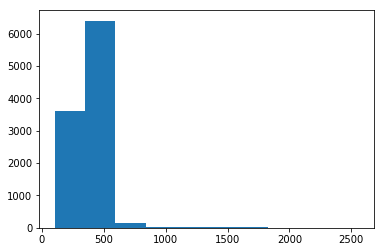

In [95]:
plt.hist(col_size)

### Training 

#### Set parameters

In [96]:
image_size = 224
arch = resnext101_64
batch_size = 28
train_file_length = df.shape[0]

#### Define get_data function to do data augmentation for different params

In [137]:
def get_data(arch, image_size, batch_size, use_full_training_set=False):
    val_idxs = None if use_full_training_set else get_cv_idxs(train_file_length)
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/labels.csv', batch_size, tfms=tfms, suffix='.jpg', val_idxs=val_idxs, test_name='test')

#### Model setup

In [99]:
data = get_data(arch, image_size, batch_size)
learn = ConvLearner.pretrained(arch, data, precompute=False)

C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
C:\Users\I863552\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\fastai\initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


#### Learn with image isze 224

In [100]:
learn.lr_find()

 85%|███████████████████████████████████████████████████████████████▏          | 250/293 [16:54<02:53,  4.03s/it, loss=9.23]

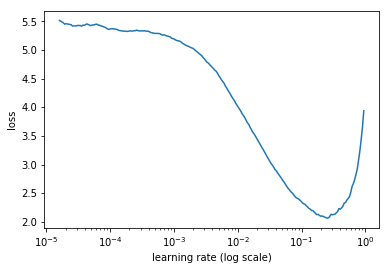

In [101]:
learn.sched.plot()

In [103]:
learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                   
    0      0.615831   0.277374   0.906556  
    1      0.545404   0.264125   0.913405                                                                                   


[0.26412468378062115, 0.9134051228222781]

In [106]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9197651663405088, 0.2562789846147671)

In [107]:
learn.save('last_224')

In [124]:
learn.load('last_224')

#### Learn with Image size 270

In [133]:
batch_size = 10
learn.set_data(get_data(arch, 270, batch_size))

In [134]:
learn.lr_find()

 72%|████████████████████████████████████████████████████▉                     | 585/818 [21:59<08:30,  2.19s/it, loss=1.63]

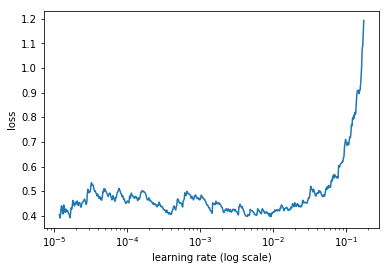

In [135]:
learn.sched.plot()

In [136]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                                   
    0      0.361433   0.23544    0.924168  
    1      0.388783   0.217777   0.929061                                                                                   
    2      0.269502   0.209293   0.932975                                                                                   
    3      0.374709   0.211132   0.933953                                                                                   
    4      0.244373   0.206086   0.933464                                                                                   
    5      0.200205   0.196654   0.934932                                                                                   
    6      0.231063   0.1934     0.935421                                                                                   


[0.193400268276849, 0.9354207539045181]

In [138]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9403131115459883, 0.1872206375057148)

In [139]:
learn.save('last_270')

In [140]:
learn.load('last_270')

#### Learn with two epochs per cycle

In [143]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                                                                                   
    0      0.215995   0.20751    0.933953  
    1      0.221659   0.190905   0.941292                                                                                   


[0.1909053924670279, 0.9412915967915156]

In [144]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9417808219178082, 0.18531606869174128)

In [145]:
learn.save('last_270_cycle_2')

In [146]:
learn.load('last_270_cycle_2')

### Generate output

In [151]:
log_preds, y = learn.TTA(is_test=True)

In [152]:
probs = np.mean(np.exp(log_preds), 0)

In [153]:
submit_df = pd.DataFrame(probs)
submit_df.columns = data.classes
submit_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,4.834102e-09,4.355550e-08,3.876562e-08,2.175530e-09,4.236528e-11,9.909140e-10,7.161697e-11,8.400049e-11,3.820907e-09,2.474053e-10,...,3.921362e-09,7.549177e-10,3.652739e-09,3.209318e-11,1.422727e-09,1.174035e-09,8.915237e-10,9.993027e-09,4.355581e-08,3.770044e-09
1,4.221547e-10,4.450466e-11,5.892450e-10,5.466967e-11,8.425902e-12,6.693747e-10,4.157698e-10,8.482861e-11,1.756156e-10,1.549563e-10,...,3.055317e-10,2.951994e-11,5.758611e-11,1.055312e-12,4.920465e-09,9.764428e-10,5.276398e-07,6.441013e-11,6.711729e-10,1.506249e-11
2,1.305640e-11,3.371915e-08,1.163033e-09,4.626399e-11,1.112048e-12,2.314831e-11,9.149927e-12,4.125299e-13,1.301926e-10,4.158079e-12,...,1.974644e-11,1.254403e-11,8.358226e-12,9.744035e-11,3.976827e-10,6.740107e-08,1.564678e-12,2.482762e-11,2.279589e-11,8.462171e-11
3,2.595160e-02,3.878163e-05,1.024659e-04,4.594239e-03,9.502173e-06,1.617590e-03,8.621982e-06,4.441509e-04,2.616692e-05,1.323076e-04,...,5.601831e-04,7.199783e-06,1.364313e-03,7.456335e-06,1.431824e-04,1.165098e-05,1.216035e-05,1.066452e-03,2.322817e-05,8.490178e-04
4,2.081964e-01,4.649780e-06,3.332705e-07,1.737867e-06,1.666894e-07,4.688316e-07,1.115694e-05,8.384828e-08,8.849059e-07,2.271098e-07,...,3.470456e-06,2.071163e-07,5.129667e-07,4.678199e-08,1.463881e-08,1.967276e-06,6.350263e-07,5.178881e-07,8.700481e-05,8.347528e-05


In [154]:
submit_df.insert(0, 'id', [filename[5:-4] for filename in data.test_ds.fnames])
submit_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,4.834102e-09,4.355550e-08,3.876562e-08,2.175530e-09,4.236528e-11,9.909140e-10,7.161697e-11,8.400049e-11,3.820907e-09,...,3.921362e-09,7.549177e-10,3.652739e-09,3.209318e-11,1.422727e-09,1.174035e-09,8.915237e-10,9.993027e-09,4.355581e-08,3.770044e-09
1,00102ee9d8eb90812350685311fe5890,4.221547e-10,4.450466e-11,5.892450e-10,5.466967e-11,8.425902e-12,6.693747e-10,4.157698e-10,8.482861e-11,1.756156e-10,...,3.055317e-10,2.951994e-11,5.758611e-11,1.055312e-12,4.920465e-09,9.764428e-10,5.276398e-07,6.441013e-11,6.711729e-10,1.506249e-11
2,0012a730dfa437f5f3613fb75efcd4ce,1.305640e-11,3.371915e-08,1.163033e-09,4.626399e-11,1.112048e-12,2.314831e-11,9.149927e-12,4.125299e-13,1.301926e-10,...,1.974644e-11,1.254403e-11,8.358226e-12,9.744035e-11,3.976827e-10,6.740107e-08,1.564678e-12,2.482762e-11,2.279589e-11,8.462171e-11
3,001510bc8570bbeee98c8d80c8a95ec1,2.595160e-02,3.878163e-05,1.024659e-04,4.594239e-03,9.502173e-06,1.617590e-03,8.621982e-06,4.441509e-04,2.616692e-05,...,5.601831e-04,7.199783e-06,1.364313e-03,7.456335e-06,1.431824e-04,1.165098e-05,1.216035e-05,1.066452e-03,2.322817e-05,8.490178e-04
4,001a5f3114548acdefa3d4da05474c2e,2.081964e-01,4.649780e-06,3.332705e-07,1.737867e-06,1.666894e-07,4.688316e-07,1.115694e-05,8.384828e-08,8.849059e-07,...,3.470456e-06,2.071163e-07,5.129667e-07,4.678199e-08,1.463881e-08,1.967276e-06,6.350263e-07,5.178881e-07,8.700481e-05,8.347528e-05


In [155]:
submit_dir = f'submit'
os.makedirs(submit_dir, exist_ok=True)
submit_df.to_csv(f'{submit_dir}/submit.gz', compression='gzip', index=False)

In [156]:
FileLink(f'{submit_dir}/submit.gz')

C:\Users\I863552\Documents\fastai\courses\dl1\kaggle\submit\submit.gz